<a href="https://colab.research.google.com/github/kdenning/Political-ANN/blob/master/CIS_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Set-up**

In [23]:
# importing the data
import pandas as pd
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTl96SRjmGCo6hCFRYJzuP_v17kqx08ZC9fubES5aUOCVZjsHWXXxwPix2pvpF5WzOYyHb1SCbaEBDF/pub?output=csv'
pt_table = pd.read_csv(url, error_bad_lines=False, encoding='utf-8', delimiter=",")
pd.set_option('display.max_columns', None)
pt_table.head()

,subid,PoliOrient_1,VotePref,Day_Clin_In_PT,Day_Clin_In_C,Day_Clin_Out_PT,Day_Clin_Out_C,Day_Trump_Out_PT,Day_Trump_Out_C,Day_Trump_In_PT,Day_Trump_In_C
0,1,2,1,NaN,NaN,NaN,Jen gets up and feeds her 5 kids. She goes to ...,NaN,NaN,NaN,NaN
1,4,5,2,NaN,NaN,NaN,NaN,NaN,I BELIEVE A TYPICAL DAY FOR JEN IS FILLED WITH...,NaN,NaN
2,5,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"She wakes up early, gets ready for work, makes..."
3,6,1,1,NaN,Jen is a graudate student in Social work and t...,NaN,NaN,NaN,NaN,NaN,NaN
4,7,3,1,"A feminist goes about her day, ranting about h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# getting data in long format
table_long = pd.melt(pt_table, id_vars=['subid', 'VotePref'], value_vars=['Day_Clin_In_PT', 'Day_Clin_In_C', 'Day_Clin_Out_PT', 'Day_Clin_Out_C', 'Day_Trump_Out_PT', 'Day_Trump_Out_C', 'Day_Trump_In_PT', "Day_Trump_In_C" ])
# removing NaN's
long_nonan = table_long.dropna()
# checking the data looks right and is the right number of rows; should be 773
print(long_nonan.head())
print(len(long_nonan))

    subid  VotePref        variable  \
4       7         1  Day_Clin_In_PT   
8      11         1  Day_Clin_In_PT   
18     21         1  Day_Clin_In_PT   
20     23         1  Day_Clin_In_PT   
27     30         1  Day_Clin_In_PT   

                                                value  
4   A feminist goes about her day, ranting about h...  
8   I am a gym teacher. My typical week begins wit...  
18  I think Jen is a very intelligent hard working...  
20  I wake up in the morning, take a shower then e...  
27                   She wants equality for everyone.  
773


In [21]:
# Looking at the types of variables in my set, so that I can recode VotPref
print(long_nonan.dtypes)

subid        int64
VotePref     int64
variable    object
value       object
dtype: object


In [25]:
# make the outcome variable binary (1, 0)
long_nonan.replace({'VotePref': 2}, 0) # Now 1 = voted for Clinton, 0 = voted for Trump

,subid,VotePref,variable,value
4,7,1,Day_Clin_In_PT,"A feminist goes about her day, ranting about h..."
8,11,1,Day_Clin_In_PT,I am a gym teacher. My typical week begins wit...
18,21,1,Day_Clin_In_PT,I think Jen is a very intelligent hard working...
20,23,1,Day_Clin_In_PT,"I wake up in the morning, take a shower then e..."
27,30,1,Day_Clin_In_PT,She wants equality for everyone.
...,...,...,...,...
6148,773,0,Day_Trump_In_C,Jen wakes up. Turns on the news. Goes to work....
6154,779,0,Day_Trump_In_C,She gets up like everyone else. She goes to wo...
6162,787,0,Day_Trump_In_C,"Wake up and take the kids to all white school,..."
6173,799,0,Day_Trump_In_C,Jen's typical day would be to care for her fam...


In [26]:
# Getting puddles and spacey loaded
!rm -r  'uo_puddles'
puddles = 'uo-puddles' 
clone_url = f'https://github.com/{puddles}/uo_puddles.git'
!git clone $clone_url 
import uo_puddles.uo_puddles as up

import spacy
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()  

rm: cannot remove 'uo_puddles': No such file or directory
Cloning into 'uo_puddles'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 282 (delta 2), reused 0 (delta 0), pack-reused 276
Receiving objects: 100% (282/282), 76.59 KiB | 6.96 MiB/s, done.
Resolving deltas: 100% (169/169), done.
     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=12a39eccc6b1900b3142656c1b56d0a038ce609fe9c2b16480cca08d10051c22
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kzq43ub/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [27]:
# Adding my github repo of functions for this final project
!rm -r  'python_library_final_proj'
github_name = 'kdenning' 
clone_url = f'https://github.com/{github_name}/python_library_final_proj.git'
!git clone $clone_url
import python_library_final_proj.functions as func

rm: cannot remove 'python_library_final_proj': No such file or directory
Cloning into 'python_library_final_proj'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [28]:
# Shuffle table to prep for data split
import numpy as np
rsgen = np.random.RandomState(1234)

shuffled_table = long_nonan.sample(frac=1, random_state=rsgen).reset_index(drop=True)
shuffled_table.head()

# Pulling out strings
text = shuffled_table['value'].tolist()
vote = shuffled_table['VotePref'].tolist() 

print(text[:10])

['Jen gets up and goes to her local elementary school, where she is a kindergarten teacher. She spends all day teaching young children and then goes home to spend time with her own family. She does charity work some days, when she has time.', 'Jen is highly motivated to prove she is an independent, hard working person. She is a single parent of two children, both girls, and she wants them to growup knowing there is nothing that they can\'t do, so spends her day role modelling for them how she thinks a modern, free-thinker, conscientous woman would behave. She is environmentally aware, teaching them about recycling but dumps her trash in the neighbor\'s front yard because she doesn\'t believe the same way. As she tells her girls sometimes you have to do bad things to get the right thing done. She doesn\'t understand why her girls are so disrepectful of her forgetting they were standing by when she yelled "Pig" at the cop who pulled her over for running that red light on her way to their

In [29]:
# Getting Glove vectors for words in shuffled text list
%%time
text_vectors = []

for i in range(len(text)):
  output = func.sent2vec(text[i])
  text_vectors.append(output)

CPU times: user 16.8 s, sys: 82 ms, total: 16.9 s
Wall time: 17 s


In [30]:
# checking the glove vectors look correct
print(text_vectors[:10])
len(text_vectors)

[[-0.02870136684668978, 0.2305650842714716, -0.030387953770431606, -0.02569695452058857, 0.013702680441466246, -0.14615431749685245, -0.03096736417236653, -0.10400868071751161, 0.18884901808236132, 2.66088407960805, -0.25022877024655993, 0.1617073181762614, -0.147464118051258, -0.0795118543213572, -0.14931478546879423, 0.13326929726595568, 0.03600486232475801, 0.8191118274222721, -0.053502209124748006, 0.08416027338667349, 0.07114722723649307, -0.24720868112688715, -0.06133252864872867, 0.10540590710429983, 0.15998908995904706, 0.05774618236517364, -0.04701917279850353, -0.05760373073545369, 0.104951272549277, -0.00613621829754927, -0.10034953332929449, -0.09678877178918231, 0.17470568232238293, -0.12227063710716637, 0.29653642870438157, 0.013018472230628091, 0.07995963604612784, -0.003425274213606661, 0.11348490992730315, 0.11851758674972436, 0.06486267774281176, 0.015237726779146627, -0.053082773461937904, -0.021848227151415565, -0.07643536245450377, 0.20500741204754871, -0.069054319

773

In [31]:
# Split data into test and training sets
X_train = text_vectors[:700]
Y_train = vote[:700]

X_test = text_vectors[700:]
Y_test = vote[700:] 

# Score to beat with ANN model
Y_test.count(1)/len(Y_test)

0.6164383561643836

In [32]:
Y_test[:20]

[1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1]

In [34]:
Y_test.count(2)/len(Y_test)

0.3835616438356164

# **ANN Model**

## Grid Searches

In [0]:
# Do grid search for best nodes and hidden layer amounts
up.grid_search([[64,1], [32, 1], [32,16,1], [16, 8, 1], [64, 32, 1], [64, 32, 16, 1], [128, 64, 32, 1], [128,1]], [10,15,20,30, 40, 50,75, 100], X_train, Y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1) ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1), total=   3.8s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1) ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


KeyboardInterrupt: ignored

In [0]:
# Can I beat the best from above? Best: 0.627141 using {'batch_size': 1, 'epochs': 30, 'input_dim': 300, 'lyrs': (128, 1)}
up.grid_search([[128,1], [256, 1], [512, 1]], [20, 30, 40, 50, 100], X_train, Y_train)

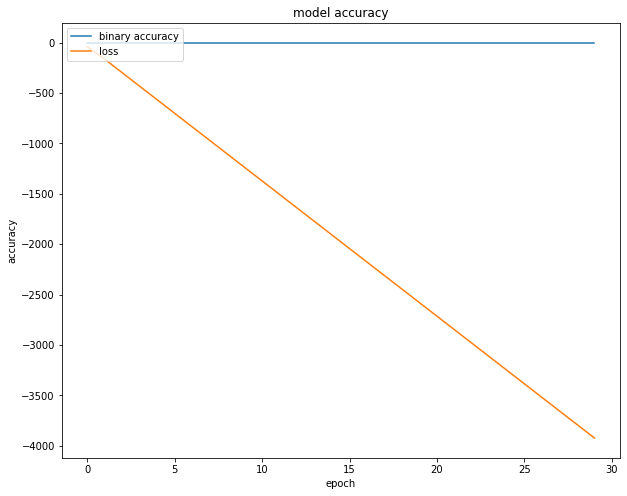

In [35]:
# Choosing the best model
m = up.ann_build_model(300, [128,1]) 

# The best epochs
training = up.ann_train(m, X_train, Y_train, 30) 

#Plot looks wrong...

In [36]:
# Predictions
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)

0.6164383561643836